# Outline

1.   Basic motivation of hyperparameter tuning
2.   Integrating Google colab with a local runtime (config in Google colab, Browser, Jupyter notebook)
3.   Installing MLFlow and basic use case
4.   Logging parameters, metrics with MLFlow
5.   Logging image artifacts with MLFlow
6.   Logging PyTorch models with MLFlow and loading them



In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

In [4]:
!pip install mlflow
import mlflow
import mlflow.pytorch

     |████████████████████████████████| 16.0MB 293kB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 1.1MB 47.3MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
     |████████████████████████████████| 6.0MB 35.7MB/s 
     |████████████████████████████████| 460kB 45.3MB/s 
     |████████████████████████████████| 153kB 48.1MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 204kB 58.4MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.9.1-cp36-none-any.whl size=83754 sha256=1c0dd9bd4fe2815ec87b47fe52ccc1b3cb4c8e4fa349f7873b0b1dd9c806cb87
  Stored in directory: /root/.cache/pip/wheels/bc/27/58/c6ef96e649962e9584a50f58d5b6abafb71a03512b2e381ad1
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158154 sha256=3a7e00703fe42f532b12b563a3567e5df3562f3f449872e9271dc01fc0f193e6
  Stored in di

# Params

In [0]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(256, 4, 0, 20)

# Dataset

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST('../data', train=True, download=True, 
                         transform=transform)

test_set = datasets.MNIST('../data', train=False, download=True, 
                         transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


# Model

In [0]:
class Model(nn.Module):
    def __init__(self, nH = 32): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [0]:
def train(epoch):
    
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))

In [0]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10, 10])
    
    with torch.no_grad():
        
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]
            correct += pred.eq(labels.data).sum().item()
            
            for x, y in zip(pred.numpy(), labels.numpy()):
                confusion_matrix[x][y] += 1
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100.0 * correct / len(test_loader.dataset)
        
        pos = (epoch + 1) * len(train_loader)
        mlflow.log_metric('test_loss', test_loss*1000)
        mlflow.log_metric('test_accuracy', test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset), test_accuracy))
              
        if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                       yticks=np.arange(confusion_matrix.shape[0]),
                       xticklabels=classes, yticklabels=classes,
                       ylabel='True label',
                       xlabel='Predicted label',
                       title='Epoch %d' % epoch)
            thresh = confusion_matrix.max() / 2.
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j, i, int(confusion_matrix[i, j]),
                            ha="center", va="center",
                            color="white" if confusion_matrix[i, j] > thresh else "black")
              
            fig.tight_layout()
              
            image_path = 'images/%s.png' % (expt_id)
            plt.savefig(image_path)
            mlflow.log_artifact(image_path)
            

# Hyperparameter tuning loop

INFO: 'Fixed nH' does not exist. Creating a new experiment

LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.029
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.457
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.386
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.358
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.279
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.247
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.264
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.266
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.289
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.313
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.258

Test set: Average loss: 0.0010, Accuracy: 9251/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.252
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.336
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.214
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.268
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.238
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.362


FileNotFoundError: ignored

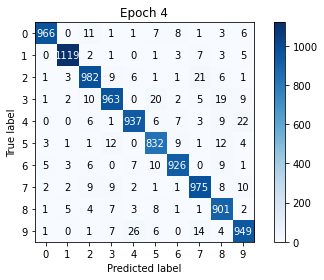

In [10]:
# expt_id = mlflow.create_experiment('Fixed nH')

mlflow.set_experiment('Fixed nH')

for lr in [0.01, 0.02, 0.05, 0.1]:
    for momentum in [0.9, 0.95, 0.99]:
        for hidden_nodes in [48]:
        
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = Model(hidden_nodes)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            with mlflow.start_run() as run:  
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1):
                    train(epoch)
                    test(epoch)

                mlflow.pytorch.log_model(model, "models")

# Loading and visualising a model

In [11]:
model_load = mlflow.pytorch.load_model('models', run_id="9a5e902876654a88b9876e481aa37b27")

OSError: ignored

In [13]:
print(model_load)

NameError: ignored

In [14]:
weight_layer0 = list(model_load.parameters())[0].data.numpy()

NameError: ignored

In [15]:
print(weight_layer0.shape)

NameError: ignored

In [12]:
sns.distplot(weight_layer0.ravel())
plt.plot()

NameError: ignored

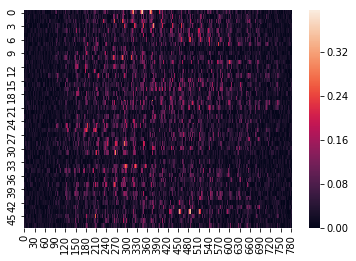

In [0]:
sns.heatmap(np.abs(weight_layer0))
plt.show()

In [0]:
weight_layer1 = list(model_load.parameters())[2].data.numpy()

In [0]:
weight_layer1.shape

(10, 48)

[]

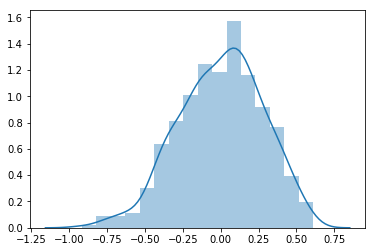

In [0]:
sns.distplot(weight_layer1.ravel())
plt.plot()

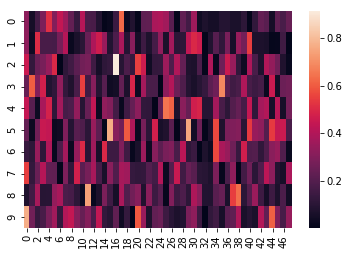

In [0]:
sns.heatmap(np.abs(weight_layer1))
plt.show()

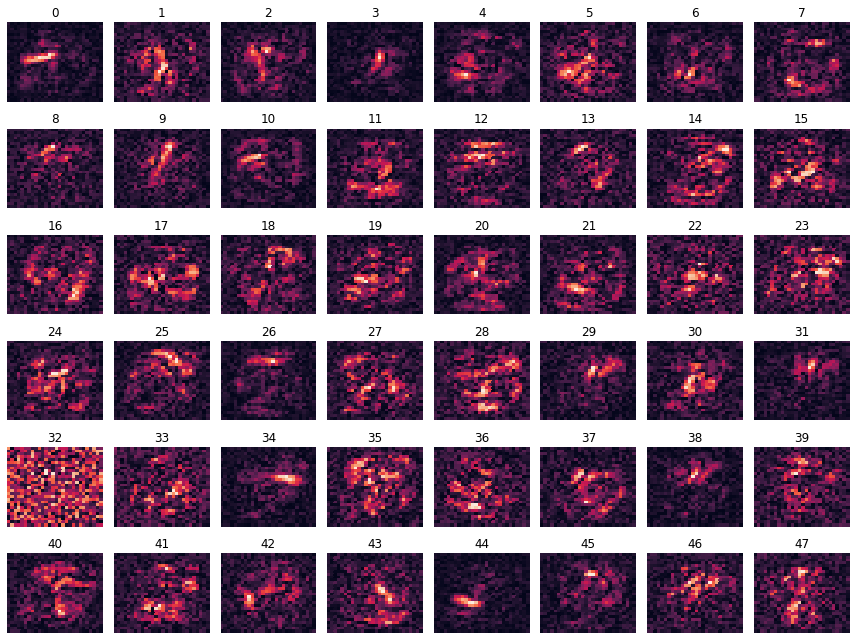

In [0]:
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48): 
    ax1 = fig.add_subplot(nrows, ncols, i+1)
    sns.heatmap(np.abs((weight_layer0[i, 0:784]).reshape(28, 28)), ax = ax1, cbar=False)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title(i)
plt.tight_layout()
plt.show()